In [144]:
import sys
sys.path.append('../')

import pickle

with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)

In [145]:
sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]

[('lsq_period', 0.1034570933941395),
 ('max_time_lag', 0.06138296255084765),
 ('amp_0', 0.041736272085388174),
 ('ks_p84_p16', 0.037906107217302455),
 ('ks_p75_p25', 0.03243375878949996),
 ('JK_col', 0.03172926261046019),
 ('peak_ratio_model', 0.02864340889498028),
 ('ks_mad', 0.028165569050756057),
 ('max_pow', 0.025827574049644024),
 ('ks_p95_p5', 0.022912131635568486),
 ('a0_a1', 0.0226136636576045),
 ('ks_stetson_i', 0.02174177428473977),
 ('amp_1', 0.021450025029441887),
 ('amplitude', 0.021157818588017865),
 ('amp_3', 0.02113742657011694),
 ('ks_p99_p1_over_error', 0.02079425675886282),
 ('a1_a3_double', 0.02063336092592927),
 ('ks_stdev_over_error', 0.020229854211810398),
 ('ks_p95_p5_over_error', 0.019241852045780387),
 ('a0_a1_double', 0.019100177765119183),
 ('ks_mad_over_error', 0.017606176759218623),
 ('ks_p75_p25_over_error', 0.017253904339755034),
 ('a0_a3', 0.017158742169241445),
 ('ks_p84_p16_over_error', 0.01642185221343721),
 ('delta_loglik', 0.01580337492885991),
 ('

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[]

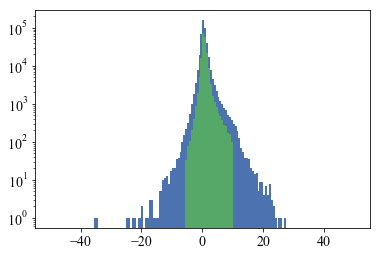

In [146]:
plt.hist(var_dataset_full['ks_skew'],bins=160,range=[-50,50])
plt.hist(var_dataset['ks_skew'],bins=160,range=[-50,50])
plt.semilogy()

In [147]:
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')

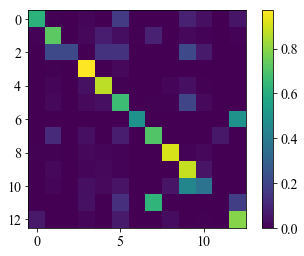

In [148]:
plt.imshow(var.cm/np.nansum(var.cm,axis=1)[:,np.newaxis])
plt.colorbar()

In [151]:
fltr = (var_dataset['var_class']=='EA/EB')&(var_dataset['log10_fap']<-10)#&(var_dataset['significant_second_minimum'])
np.count_nonzero((var_dataset['class']==var_dataset['var_class'])[fltr]) / np.count_nonzero(fltr)

0.9705728191688506

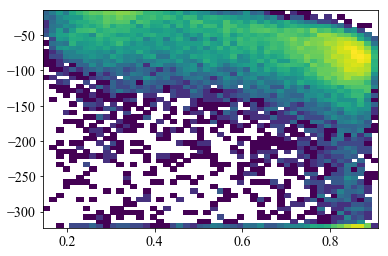

In [131]:
plt.hist2d(var_dataset['prob'][var_dataset['var_class']=='RRab'],
           var_dataset['log10_fap'][var_dataset['var_class']=='RRab'],bins=50,norm=LogNorm());